In [20]:
import os
import json
import csv
import random
import pickle
import cv2
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from scipy.ndimage import label
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import cv2
from dataset import GlaucomaDataset

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
from PIL import Image
from sklearn.model_selection import train_test_split



from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import maskrcnn_resnet50_fpn

import os
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision
from torchvision.transforms import functional as F


In [21]:


# class GlaucomaDataset(Dataset):
#     def __init__(self, root_dir, split='train', output_size=(256,256), max_images=None):
#         self.output_size = output_size
#         self.root_dir = root_dir
#         self.split = split
#         self.images = []
#         self.segs = []
#         self.max_images = max_images
#         self.img_width, self.img_height = output_size

#         # Load data index
#         for direct in self.root_dir:
#             self.image_filenames = []
#             for path in os.listdir(os.path.join(direct, "Images_Square")):
#                 if(not path.startswith('.')):
#                     self.image_filenames.append(path)

#             num_images = 0
#             for k in range(len(self.image_filenames)):
#                 # Skip loading if max_images is specified and the limit has been reached
#                 if max_images is not None and num_images >= max_images:
#                     break

#                 print('Loading {} image {}/{}...'.format(split, k, len(self.image_filenames)), end='\r')
#                 img_name = os.path.join(direct, "Images_Square", self.image_filenames[k])
#                 img = np.array(Image.open(img_name).convert('RGB'))

#                 if split != 'test':
#                     seg_name = os.path.join(direct, "Masks_Square", self.image_filenames[k][:-3] + "png")
#                     mask = np.array(Image.open(seg_name, mode='r'))
#                     od = (mask==1.).astype(np.float32)
#                     oc = (mask==2.).astype(np.float32)
                    
#                     # Check if both masks are not empty, i.e., they contain at least one non-zero pixel
#                     if np.any(od) and np.any(oc):
#                         img = transforms.functional.to_tensor(img)
#                         img = transforms.functional.resize(img, output_size, interpolation=Image.BILINEAR)
#                         self.images.append(img)
#                         od = torch.from_numpy(od[None,:,:])
#                         oc = torch.from_numpy(oc[None,:,:])
#                         od = transforms.functional.resize(od, output_size, interpolation=Image.Resampling.NEAREST)
#                         oc = transforms.functional.resize(oc, output_size, interpolation=Image.Resampling.NEAREST)
#                         self.segs.append(torch.cat([od, oc], dim=0))
#                         num_images += 1

#             print('Succesfully loaded {} dataset.'.format(split) + ' '*50)
#     # def __init__(self, root_dir, split='train', output_size=(256,256), max_images=None):
#     #     self.output_size = output_size
#     #     self.root_dir = root_dir
#     #     self.split = split
#     #     self.images = []
#     #     self.segs = []
#     #     self.max_images = max_images
#     #     self.img_width, self.img_height = output_size

#     #     # Load data index
#     #     for direct in self.root_dir:
#     #                 self.image_filenames = []
#     #                 for path in os.listdir(os.path.join(direct, "Images_Square")):
#     #                     if(not path.startswith('.')):
#     #                         self.image_filenames.append(path)

#     #                 num_images = 0
#     #                 for k in range(len(self.image_filenames)):
#     #                     # Skip loading if max_images is specified and the limit has been reached
#     #                     if max_images is not None and num_images >= max_images:
#     #                         break

#     #                     print('Loading {} image {}/{}...'.format(split, k, len(self.image_filenames)), end='\r')
#     #                     img_name = os.path.join(direct, "Images_Square", self.image_filenames[k])
#     #                     img = np.array(Image.open(img_name).convert('RGB'))

#     #                     if split != 'test':
#     #                         seg_name = os.path.join(direct, "Masks_Square", self.image_filenames[k][:-3] + "png")
#     #                         mask = np.array(Image.open(seg_name, mode='r'))
#     #                         od = (mask==1.).astype(np.float32)
#     #                         oc = (mask==2.).astype(np.float32)
                            
#     #                         # Check if both masks are not empty, i.e., they contain at least one non-zero pixel
#     #                         if np.any(od) and np.any(oc):
#     #                             img = transforms.functional.to_tensor(img)
#     #                             img = transforms.functional.resize(img, output_size, interpolation=Image.BILINEAR)
#     #                             self.images.append(img)
#     #                             od = torch.from_numpy(od[None,:,:])
#     #                             oc = torch.from_numpy(oc[None,:,:])
#     #                             od = transforms.functional.resize(od, output_size, interpolation=Image.Resampling.NEAREST)
#     #                             oc = transforms.functional.resize(oc, output_size, interpolation=Image.Resampling.NEAREST)
#     #                             self.segs.append(torch.cat([od, oc], dim=0))
#     #                             num_images += 1

#     #                 print('Succesfully loaded {} dataset.'.format(split) + ' '*50)

#     def __len__(self):
#         return len(self.images)
   
#     def __getitem__(self, idx):
#         # load image
#         img = self.images[idx]
#         # load segmentation masks (for both optic disk and optic cup)
#         seg = self.segs[idx]
#         # For instance segmentation, each mask should be a binary mask of shape (H, W).
#         # Therefore, we need to split the combined mask into two separate masks.
#         od_mask, oc_mask = seg[0], seg[1]
        

#         # Find bounding boxes around each mask. The bounding box is represented as
#         # [xmin, ymin, width, height], which is the format expected by Mask R-CNN.
#         # Find bounding boxes around each mask. The bounding box is represented as
#         # [xmin, ymin, width, height], which is the format expected by Mask R-CNN.
#         od_bbox = torch.tensor(self.mask_to_bbox(od_mask.numpy()))
#         oc_bbox = torch.tensor(self.mask_to_bbox(oc_mask.numpy()))

#         # print("od_bbox:", od_bbox, "Type:", type(od_bbox), "Shape:", od_bbox.shape)
#         # print("oc_bbox:", oc_bbox, "Type:", type(oc_bbox), "Shape:", oc_bbox.shape)



#         # od_bbox = np.array(od_bbox, dtype=np.float32)
#         # oc_bbox = np.array(oc_bbox, dtype=np.float32)
#         # boxes = torch.tensor([od_bbox, oc_bbox], dtype=torch.float32)
#         od_bbox = np.array(od_bbox)
#         oc_bbox = np.array(oc_bbox)
#         boxes = torch.tensor(np.array([od_bbox, oc_bbox]), dtype=torch.float32)





#         # Check that the bounding boxes are valid
#         img_height, img_width = self.img_height, self.img_width
#         for bbox in [od_bbox, oc_bbox]:
#                 assert bbox[0] >= 0, "xmin should be non-negative"
#                 assert bbox[1] >= 0, "ymin should be non-negative"
#                 assert bbox[2] > 0, "width should be positive"
#                 assert bbox[3] > 0, "height should be positive"
#                 try:
#                     bbox[0] = min(bbox[0], img_width - bbox[2])
#                     bbox[1] = min(bbox[1], img_height - bbox[3])
#                     assert bbox[0] + bbox[2] <= img_width, "xmin + width should be within the image width"
#                     assert bbox[1] + bbox[3] <= img_height, "ymin + height should be within the image height"
#                 except AssertionError:
#                     print(f"Error with bounding box {bbox} for image of size {img.shape}")
#                     raise

#         # The labels are a tensor of class IDs. In this case, you might want to use
#         # 1 for optic disk and 2 for optic cup, as you did when creating the masks.
#         labels = torch.tensor([0, 1], dtype=torch.int64)

#         # Now, we need to put the masks and bounding boxes into the right format.
#         # The masks should be a tensor of shape (num_objs, H, W),
#         # and the bounding boxes should be in a (num_objs, 4) tensor.
#         masks = torch.stack([od_mask, oc_mask])
#         boxes = torch.tensor([od_bbox, oc_bbox])


#         # Pack the bounding boxes and labels into a dictionary
#         target = {"boxes": boxes, "labels": labels, "masks": masks}

#         # Convert bounding box format
#         target['boxes'][:, 2] += target['boxes'][:, 0]  # xmax = xmin + width
#         target['boxes'][:, 3] += target['boxes'][:, 1]  # ymax = ymin + height

        

#         return img, target



#     @staticmethod
#     def mask_to_bbox(mask):
#         # Find the bounding box of a binary mask.
#         # This method assumes that the input is a binary mask with 0s and 1s.
#         pos = np.where(mask)
#         xmin = np.min(pos[1])
#         xmax = np.max(pos[1])
#         ymin = np.min(pos[0])
#         ymax = np.max(pos[0])
#         return [xmin, ymin, xmax - xmin, ymax - ymin]


    
#     # def __getitem__(self, idx):
#     #     # load image
#     #     img = self.images[idx]
#     #     # load segmentation masks (for both optic disk and optic cup)
#     #     seg = self.segs[idx]
#     #     # For instance segmentation, each mask should be a binary mask of shape (H, W).
#     #     # Therefore, we need to split the combined mask into two separate masks.
#     #     od_mask, oc_mask = seg[0], seg[1]

#     #     # Find bounding boxes around each mask. The bounding box is represented as
#     #     # [xmin, ymin, width, height], which is the format expected by Mask R-CNN.
#     #     od_bbox = self.mask_to_bbox(od_mask.numpy())
#     #     oc_bbox = self.mask_to_bbox(oc_mask.numpy())

#     #     # The labels are a tensor of class IDs. In this case, you might want to use
#     #     # 1 for optic disk and 2 for optic cup, as you did when creating the masks.
#     #     labels = torch.tensor([1, 2], dtype=torch.int64)

#     #     # Now, we need to put the masks and bounding boxes into the right format.
#     #     # The masks should be a tensor of shape (num_objs, H, W),
#     #     # and the bounding boxes should be in a (num_objs, 4) tensor.
#     #     masks = torch.stack([od_mask, oc_mask])
#     #     boxes = torch.tensor([od_bbox, oc_bbox])

#     #     # Pack the bounding boxes and labels into a dictionary
#     #     target = {"boxes": boxes, "labels": labels, "masks": masks}

#     #     return img, target

#     # @staticmethod
#     # def mask_to_bbox(mask):
#     #     # Find the bounding box of a binary mask.
#     #     # This method assumes that the input is a binary mask with 0s and 1s.
#     #     pos = np.where(mask)
#     #     xmin = np.min(pos[1])
#     #     xmax = np.max(pos[1])
#     #     ymin = np.min(pos[0])
#     #     ymax = np.max(pos[0])
#     #     return [xmin, ymin, xmax - xmin, ymax - ymin]


In [22]:

def get_instance_segmentation_model(num_classes):
    # Load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights='MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT')

    # Get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # And replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    # model.load_state_dict(torch.load('model_rcnn.pth'))

    return model


In [23]:
root_dirs = [ "ORIGA","G1020"]
val_dir = [ "REFUGE"]
lr = 1e-4
batch_size = 1
num_workers = 8
total_epoch = 1
max_images=None

In [24]:


train_set = GlaucomaDataset(root_dirs, 
                          split='train', max_images=max_images)


train_loader = DataLoader(train_set, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=num_workers,
                          pin_memory=True,
                         )



/Users/humzakhawar/opt/anaconda3/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Succesfully loaded train dataset.                                                  
Succesfully loaded train dataset.                                                  


In [25]:
num_classes = 3

In [26]:
# Device
# device = torch.device("cuda:0")
device = torch.device("cpu")




# Network
model = get_instance_segmentation_model(num_classes=num_classes)

# Loss
seg_loss = torch.nn.BCELoss(reduction='mean')

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
#optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [27]:
range(total_epoch)

range(0, 1)

In [28]:
# # Move model to the device
# model.to(device)

# # If more than one class is used (background is also considered a class)
# num_classes = 2

# # Initialize the metric trackers
# train_loss = []
# val_loss = []

# # Epoch loop
# for epoch in range(total_epoch):
#     model.train()
#     print("Epoch {}/{}".format(epoch+1, total_epoch))
#     print('-' * 10)
    
#     running_loss = 0.0
    
#     # Train loop
#     for i, (inputs, targets) in enumerate(train_loader):
#         inputs = inputs.to(device)
#         # targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
#         targets = [{k: v.squeeze(0).to(device) for k,v in  targets.items()}]

#         # Forward pass
#         output = model(inputs, targets)
#         loss = sum(loss for loss in output.values())

#         # Backward pass and optimization
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()

#         running_loss += loss.item() * inputs.size(0)
#         print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch+1, 
#                                                                        i * len(inputs), 
#                                                                        len(train_loader.dataset),
#                                                                        100. * i / len(train_loader),
#                                                                        loss.item()))
#     epoch_loss = running_loss / len(train_loader.dataset)
#     train_loss.append(epoch_loss)
#     print('Training Loss: {:.4f}'.format(epoch_loss))

#     # Validation loop
#     model.eval()
#     running_loss = 0.0
#     with torch.no_grad():
#         for i, (inputs, targets) in enumerate(val_loader):
#             inputs = list(img.to(device) for img in inputs)
            
#             targets = [{k: v.squeeze(0).to(device) for k,v in  targets.items()}]

#             # Forward pass
#             output = model(inputs, targets)
#             loss = sum(loss for loss in output.values())

#             running_loss += loss.item() * sum(len(img) for img in inputs)

#             print('Validate: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(i * len(inputs), 
#                                                                      len(val_loader.dataset),
#                                                                      100. * i / len(val_loader),
#                                                                      loss.item()))
#         epoch_loss = running_loss / len(val_loader.dataset)
#         val_loss.append(epoch_loss)
#         print('Validation Loss: {:.4f}'.format(epoch_loss))
#     print()

# # Save the trained model
# torch.save(model.state_dict(), 'model_rcnn.pth')





# Move model to the device
model.to(device)

# If more than one class is used (background is also considered a class)
# num_classes = 3

# Initialize the metric trackers
train_loss = []
# val_loss = []

# Epoch loop
for epoch in range(total_epoch):
    model.train()
    print("Epoch {}/{}".format(epoch+1, total_epoch))
    print('-' * 10)
    
    running_loss = 0.0
    batch_count = 0
    
    # Train loop
    for i, (inputs, targets) in enumerate(train_loader):
        inputs = [img.to(device) for img in inputs]
        targets = [{k: v.squeeze(0).to(device) for k, v in targets.items()}]

        # Forward pass
        output = model(inputs, targets)
        loss = sum(loss for loss in output.values())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item() * sum(len(img) for img in inputs)
        batch_count += len(inputs)
        
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch+1, 
                                                                       batch_count, 
                                                                       len(train_loader.dataset),
                                                                       100. * batch_count / len(train_loader.dataset),
                                                                       loss.item()))
        epoch_loss = running_loss / len(train_loader.dataset)
        train_loss.append(epoch_loss)
    print('Training Loss: {:.4f}'.format(epoch_loss))

    
    print()

# Save the trained model
torch.save(model.state_dict(), 'model_rcnn.pth')


Epoch 1/1
----------


/Users/humzakhawar/Desktop/fyp datasets/archive/dataset.py:197: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  boxes = torch.tensor([od_bbox, oc_bbox])
/Users/humzakhawar/Desktop/fyp datasets/archive/dataset.py:197: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  boxes = torch.tensor([od_bbox, oc_bbox])
/Users/humzakhawar/Desktop/fyp datasets/archive/dataset.py:197: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a singl

Train Epoch: 1 [1/1441 (0%)]	Loss: 2.465291
Train Epoch: 1 [2/1441 (0%)]	Loss: 1.715083
Train Epoch: 1 [3/1441 (0%)]	Loss: 1.488950
Train Epoch: 1 [4/1441 (0%)]	Loss: 1.570385
Train Epoch: 1 [5/1441 (0%)]	Loss: 1.532647
Train Epoch: 1 [6/1441 (0%)]	Loss: 1.170478
Train Epoch: 1 [7/1441 (0%)]	Loss: 1.351079
Train Epoch: 1 [8/1441 (1%)]	Loss: 1.100819
Train Epoch: 1 [9/1441 (1%)]	Loss: 1.058120
Train Epoch: 1 [10/1441 (1%)]	Loss: 1.091784
Train Epoch: 1 [11/1441 (1%)]	Loss: 0.897222
Train Epoch: 1 [12/1441 (1%)]	Loss: 0.957827
Train Epoch: 1 [13/1441 (1%)]	Loss: 1.066486
Train Epoch: 1 [14/1441 (1%)]	Loss: 0.837033
Train Epoch: 1 [15/1441 (1%)]	Loss: 0.772296
Train Epoch: 1 [16/1441 (1%)]	Loss: 0.997986
Train Epoch: 1 [17/1441 (1%)]	Loss: 0.860414
Train Epoch: 1 [18/1441 (1%)]	Loss: 0.768943
Train Epoch: 1 [19/1441 (1%)]	Loss: 0.703130
Train Epoch: 1 [20/1441 (1%)]	Loss: 0.691052
Train Epoch: 1 [21/1441 (1%)]	Loss: 0.645561
Train Epoch: 1 [22/1441 (2%)]	Loss: 0.705425
Train Epoch: 1 [23/

# plotting the losses

In [29]:
# train_loss

In [30]:
val_set = GlaucomaDataset(val_dir, 
                        split='val', max_images=max_images)

val_loader = DataLoader(val_set, 
                        batch_size=batch_size, 
                        shuffle=False, 
                        num_workers=num_workers,
                        pin_memory=True,
                        )


Succesfully loaded val dataset.                                                  


In [31]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
from torch.autograd import Variable


In [32]:
# inputs=[]
# targets=[]


# for i, (inputs, targets) in enumerate(val_loader):
#     inputs = [img.to(device) for img in inputs]
#     targets = [{k: v.squeeze(0).to(device) for k, v in targets.items()}]

#     # Forward pass
#     output = model(inputs, targets)
#     # Select 10 random images from the batch
#     random_indices = torch.randint(0, len(inputs), (10,))
#     random_images = inputs[random_indices]
#     # random_labels = {k: v[random_indices] for k, v in labels.items()}

#     # Get model predictions for the selected images
#     model.eval()  # Put the model in evaluation mode
#     with torch.no_grad():
#         outputs = model(random_images)

#     # Plot the original images along with their predicted masks
#     fig, axs = plt.subplots(10, 2, figsize=(10, 40))

#     for i in range(10):
#         img = random_images[i].cpu().permute(1, 2, 0).numpy()  # Move image back to cpu and convert to numpy
#         axs[i, 0].imshow(img)
#         axs[i, 0].set_title('Original Image')

#         masks = outputs[i]['masks']  # Get predicted masks
#         mask = torch.sum(masks, dim=0)  # Combine masks if there are multiple
#         mask = mask.cpu().numpy()  # Move predicted mask back to cpu and convert to numpy
#         axs[i, 1].imshow(mask, cmap='gray') # use cmap='gray' for grayscale images
#         axs[i, 1].set_title('Predicted Mask')

#     plt.show()

In [33]:
inputs1, targets1 = next(iter(val_loader))


/Users/humzakhawar/Desktop/fyp datasets/archive/dataset.py:197: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  boxes = torch.tensor([od_bbox, oc_bbox])
/Users/humzakhawar/Desktop/fyp datasets/archive/dataset.py:197: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  boxes = torch.tensor([od_bbox, oc_bbox])
/Users/humzakhawar/Desktop/fyp datasets/archive/dataset.py:197: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a singl

In [34]:
inputs, targets= inputs1, targets1

# Get a batch of validation data
inputs = [img.to(device) for img in inputs]
# targets = [{k: v.squeeze(0).to(device) for k, v in t.items()} for t in targets]

# Select 10 random images from the batch
random_indices = torch.randint(0, len(inputs), (10,))
random_images = [inputs[i] for i in random_indices.tolist()]

# Get model predictions for the selected images
model.eval()  # Put the model in evaluation mode
with torch.no_grad():
    outputs = model(random_images)



In [35]:
outputs[0]['masks'].squeeze()

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

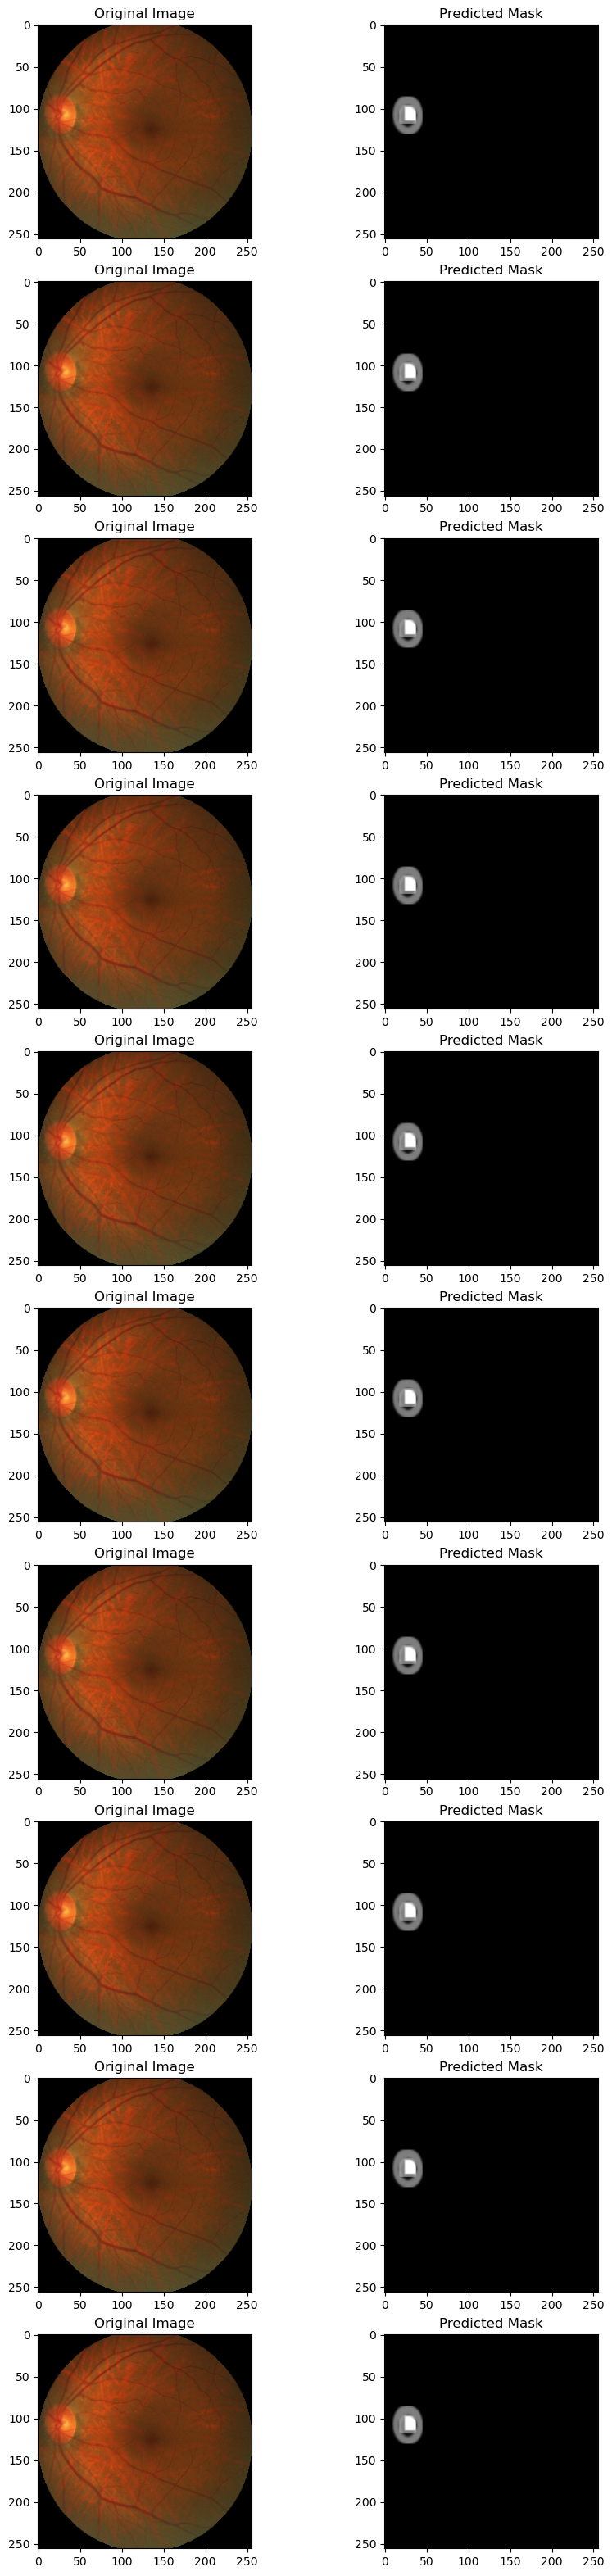

In [36]:
# Plot the original images along with their predicted masks
fig, axs = plt.subplots(10, 2, figsize=(10, 40))

for i in range(10):
    img = random_images[i].cpu().permute(1, 2, 0).numpy()  # Move image back to cpu and convert to numpy
    axs[i, 0].imshow(img)
    axs[i, 0].set_title('Original Image')

    masks = outputs[i]['masks']  # Get predicted masks
    mask = torch.sum(masks, dim=0)  # Combine masks if there are multiple
    mask = mask.cpu().squeeze().numpy()  # Squeeze the mask tensor and convert to numpy
    axs[i, 1].imshow(mask, cmap='gray') # use cmap='gray' for grayscale images
    axs[i, 1].set_title('Predicted Mask')

plt.show()

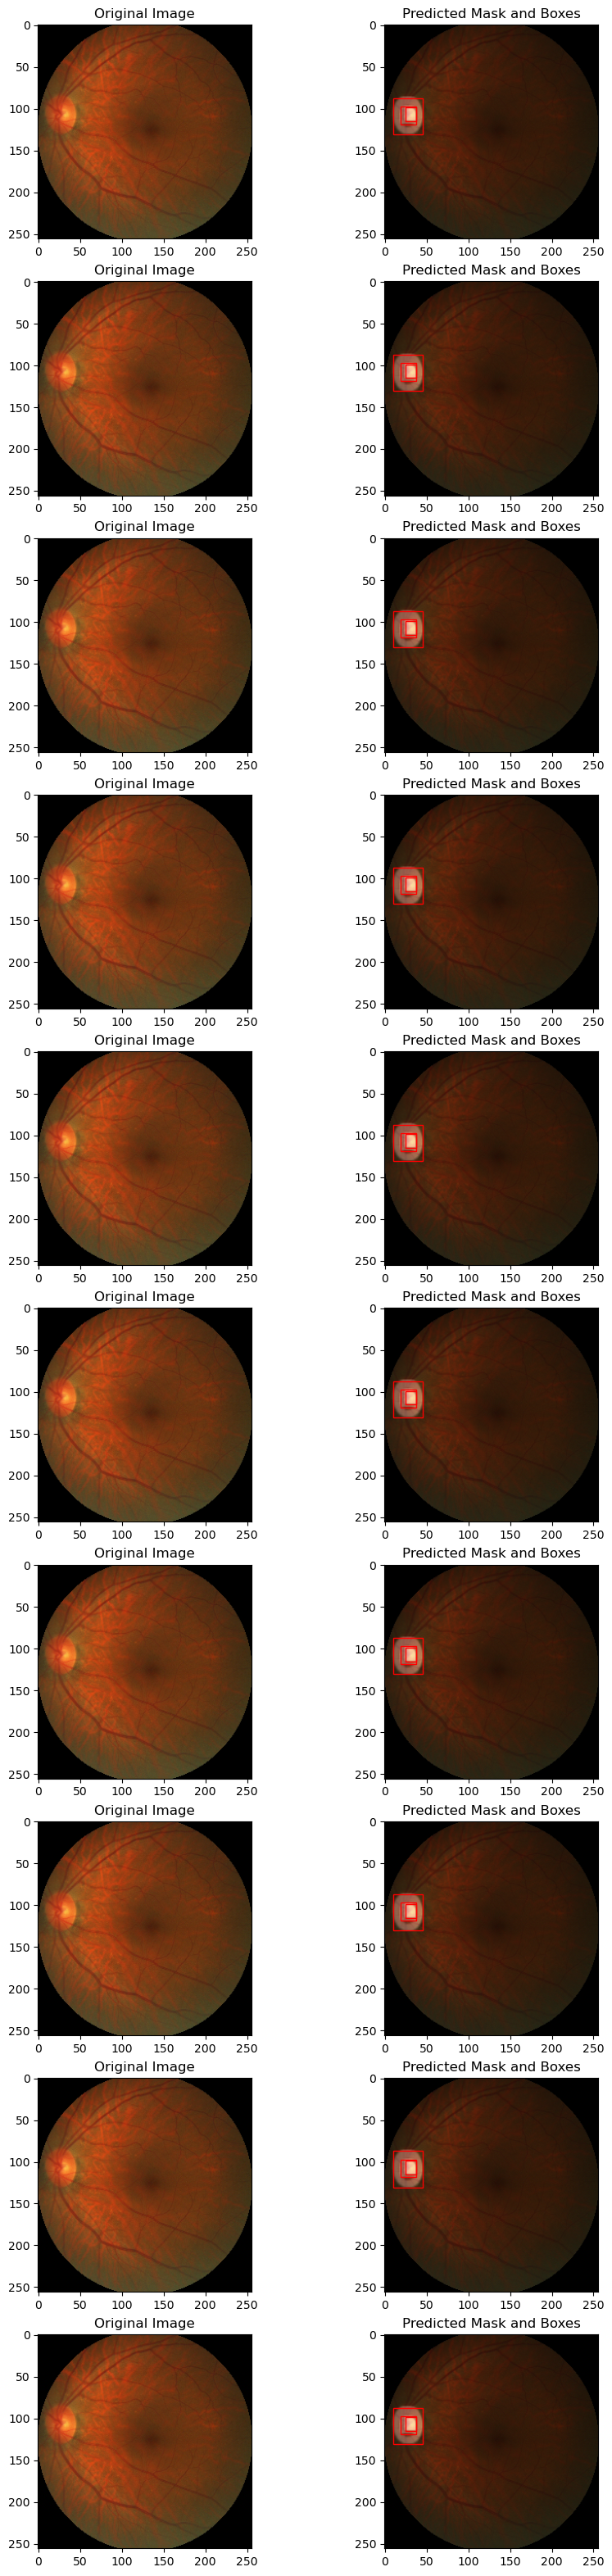

In [37]:
from matplotlib import patches

fig, axs = plt.subplots(10, 2, figsize=(10, 40))

for i in range(10):
    img = random_images[i].cpu().permute(1, 2, 0).numpy()  # Move image back to cpu and convert to numpy
    
    axs[i, 0].imshow(img)
    axs[i, 0].set_title('Original Image')

    masks = outputs[i]['masks']  # Get predicted masks
    mask = torch.sum(masks, dim=0)  # Combine masks if there are multiple
    mask = mask.cpu().squeeze().numpy()  # Squeeze the mask tensor and convert to numpy
    axs[i, 1].imshow(img)
    axs[i, 1].set_title('Predicted Mask and Boxes')

    # Overlay the mask
    axs[i, 1].imshow(mask, cmap='gray', alpha=0.5)  # Adjust alpha to control the transparency of the mask

    # Get the bounding boxes and draw them
    boxes = outputs[i]['boxes'].cpu().numpy()
    for box in boxes:
        rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none')
        axs[i, 1].add_patch(rect)

plt.show()


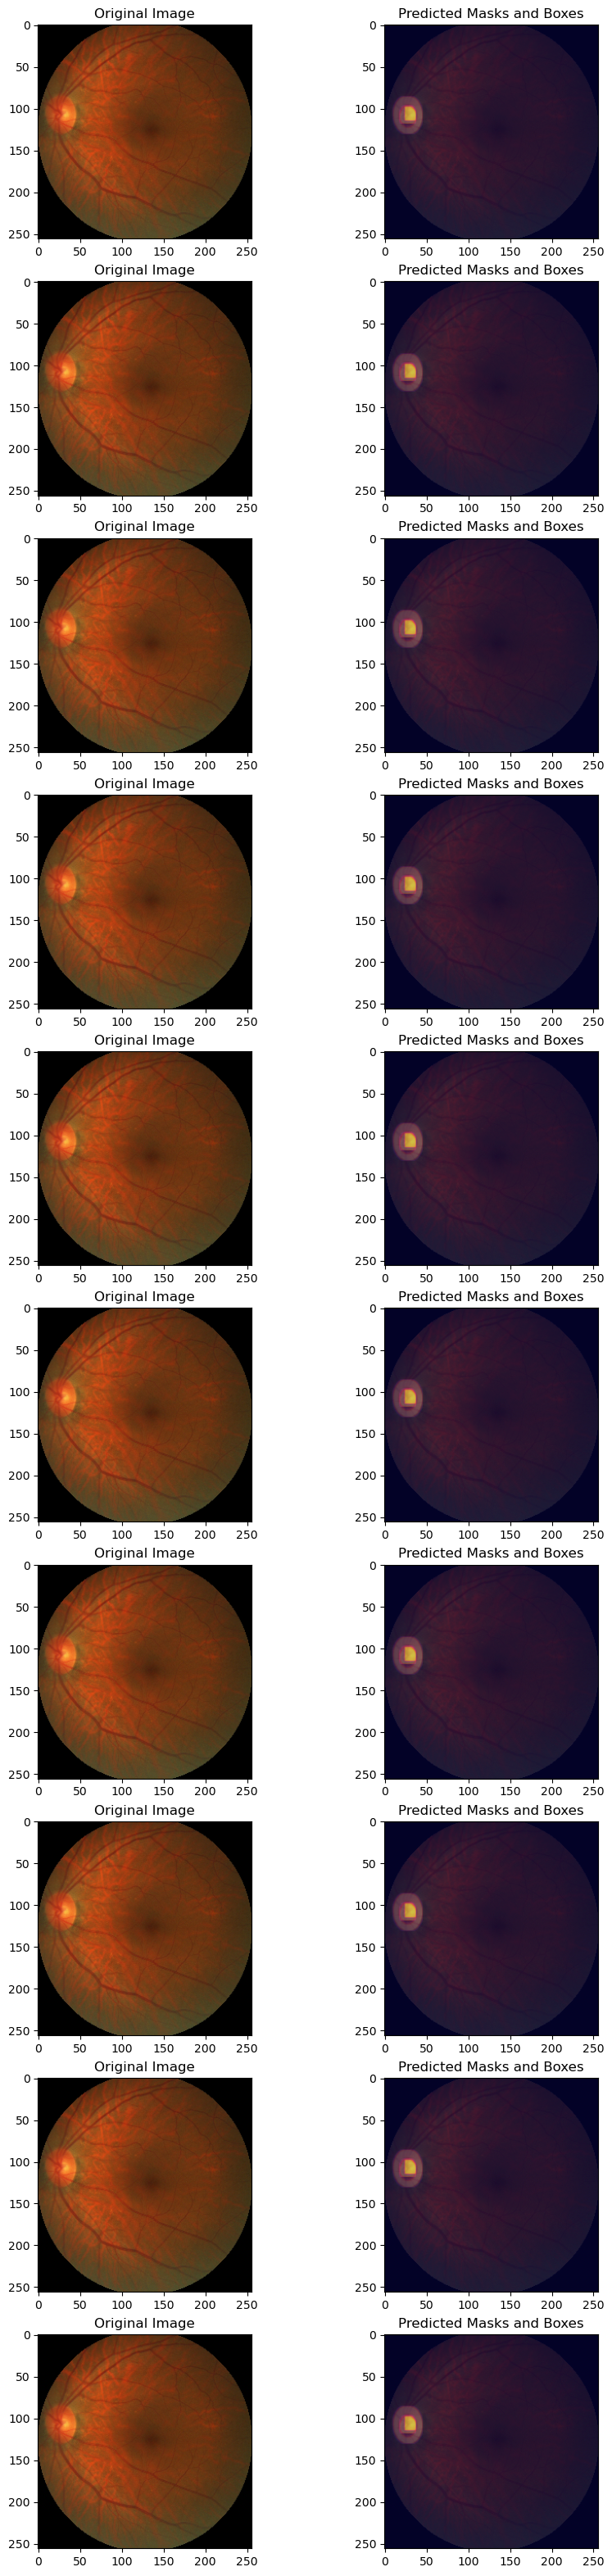

In [38]:


# Generate a list of color maps
cmaps = [plt.get_cmap(name) for name in plt.colormaps()]

fig, axs = plt.subplots(10, 2, figsize=(10, 40))

for i in range(10):
    img = random_images[i].cpu().permute(1, 2, 0).numpy()  # Move image back to cpu and convert to numpy

    axs[i, 0].imshow(img)
    axs[i, 0].set_title('Original Image')

    masks = outputs[i]['masks']  # Get predicted masks
    axs[i, 1].imshow(img)
    axs[i, 1].set_title('Predicted Masks and Boxes')

    # Overlay each mask with a different color
    for j in range(masks.shape[0]):
        mask = masks[j].cpu().squeeze().numpy()
        axs[i, 1].imshow(mask, cmap=cmaps[j % len(cmaps)], alpha=0.3)  # Adjust alpha to control the transparency

    # # Get the bounding boxes and draw them
    # boxes = outputs[i]['boxes'].cpu().numpy()
    # for box in boxes:
    #     rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none')
    #     axs[i, 1].add_patch(rect)

plt.show()


In [78]:
test_set = GlaucomaDataset(val_dir, 
                        split='val', max_images=max_images)

test_loader = DataLoader(test_set, 
                        batch_size=batch_size, 
                        shuffle=False, 
                        num_workers=num_workers,
                        pin_memory=True,
                        )


/Users/humzakhawar/opt/anaconda3/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Succesfully loaded val dataset.                                                  


In [79]:
from torchvision.transforms import ToPILImage

def get_prediction(img, threshold):

    to_pil = ToPILImage()
    img = to_pil(img)

    img = F.to_tensor(img).unsqueeze_(0)
    img = img.to(device)
    pred = model(img)
    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1]
    masks = (pred[0]['masks'] > 0.5).squeeze().detach().cpu().numpy()
    pred_class = [int(i) for i in list(pred[0]['labels'].cpu().numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return masks, pred_boxes, pred_class

def calculate_iou(prediction, ground_truth):
    intersection = np.logical_and(ground_truth, prediction)
    union = np.logical_or(ground_truth, prediction)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score


In [80]:



# Initialize the prediction and ground_truth lists
predictions, ground_truths = [], []

In [81]:
from tqdm import tqdm

print("Starting prediction...")
print("Number of test images: {}".format(len(test_set)))
# Loop through the test data loader
for images, targets in test_set:



    

    images = list(image.to(device) for image in images)
    targets = [{k: v.squeeze(0).to(device) for k, v in targets.items()}]

    # Make predictions
    
    with torch.no_grad():
        model.eval()
        print("Getting predictions... images: {}".format(len(images)))
        for image in images:
            

            masks, _, _ = get_prediction(image, threshold=0.5)
            predictions.append(masks)

    # Extract the ground truth masks
    print("Getting ground truths...")
    for target in targets:
        ground_truths.append(target['masks'].cpu().numpy())

print("Prediction complete!")

Starting prediction...
Number of test images: 1200
Getting predictions... images: 3


/Users/humzakhawar/Desktop/fyp datasets/archive/dataset.py:197: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  boxes = torch.tensor([od_bbox, oc_bbox])


Getting ground truths...
Getting predictions... images: 3
Getting ground truths...
Getting predictions... images: 3


IndexError: list index out of range

In [ ]:
iou_list = []

In [ ]:
for prediction_masks, ground_truth_masks in zip(predictions, ground_truths):
    # Ensure we have the same number of masks
    # assert prediction_masks.shape[0] == ground_truth_masks.shape[0]

    iou_scores = []
    for i in range(prediction_masks.shape[0]):
        prediction_mask = prediction_masks[i]
        ground_truth_mask = ground_truth_masks[i]
        iou = calculate_iou(prediction_mask, ground_truth_mask)
        iou_scores.append(iou)

    # Add the average IoU for this image to the list
    iou_list.append(sum(iou_scores) / len(iou_scores))
